In [67]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from scipy.stats import norm
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

In [66]:
#load the training datasets
ge_df = pd.read_csv("datasets/merged-combat15.csv")
pos_outcome_df = pd.read_csv("datasets/combat15outcomes.csv")
#pCR
pcr_df = pos_outcome_df[["patient_ID", "pCR"]].dropna(axis=0, subset=["pCR"])
pcr_df.pCR = pcr_df.pCR.astype(int)
#post_outcome (DFS, RFS)
outcome_df = pos_outcome_df[["patient_ID", "posOutcome"]].dropna(axis=0, subset=["posOutcome"])
outcome_df.posOutcome = outcome_df.posOutcome.astype(int)
ge_pcr_df = pd.merge(pcr_df, ge_df, on="patient_ID")
ge_outcome_df = pd.merge(outcome_df, ge_df, on="patient_ID")

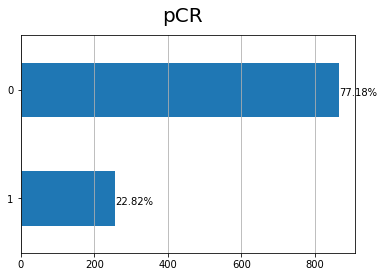

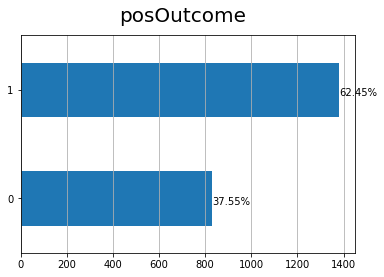

In [68]:
#show percentages of RFS = 1 and RFS = 2
def plot_percentages(x, y):
    totals = []
    for i in x.patches:
        totals.append(i.get_width())
    total = sum(totals)
    for i in x.patches:
         x.text(i.get_width()+.3, i.get_y()+.20,
         str(round((i.get_width()/total)*100, 2))+'%',
         fontsize=10, color='black')
    x.grid(axis="x")
    plt.suptitle(y, fontsize=20)
    plt.show()

ax1 = ge_pcr_df["pCR"].value_counts().sort_values().plot(kind="barh")


plot_percentages(ax1, "pCR")

ax2 = ge_outcome_df["posOutcome"].value_counts().sort_values().plot(kind="barh")
plot_percentages(ax2, "posOutcome")

In [69]:
X_pcr, y_pcr = ge_pcr_df[ge_pcr_df.columns.difference((["patient_ID", "pCR"]))], ge_pcr_df["pCR"]
X_outcome, y_outcome = ge_outcome_df[ge_outcome_df.columns.difference(["patient_ID", "posOutcome"])], ge_outcome_df["posOutcome"]

In [70]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time

    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

#A paramater grid for XGboost
params = {'n_estimators': [300, 400, 500, 600, 700],
              'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.07],
              'gamma': [0.5, 1, 1.5, 2, 5],
              'max_depth': [3, 4, 5, 6],
              'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0],
              'min_child_weight': [1, 2, 3, 4, 5]
  }
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
n_folds = 5
param_comb = 25

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)


In [30]:
#posOutcome

rand_search_outcome = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=12,
                                   cv=skf.split(X_outcome, y_outcome), verbose=3, random_state=42)

start_time = timer(None) # timing starts from this point for "start_time" variable
rand_search_outcome.fit(X_outcome, y_outcome)
timer(start_time)
print("Best Score: {:.3%}".format(rand_search_outcome.best_score_))
print(rand_search_outcome.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[18:34:16] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:34:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 2 hours 45 minutes and 40.92 seconds.
Best Score: 80.583%
{'subsample': 0.6, 'n_estimators': 700, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 0.5, 'colsample_bytree': 0.8}


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed: 11.5min
[Parallel(n_jobs=12)]: Done 125 out of 125 | elapsed: 151.3min finished


In [22]:
#pcr

rand_search_pcr = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=12,
                                   cv=skf.split(X_pcr, y_pcr), verbose=3, random_state=42)

start_time = timer(None) # timing starts from this point for "start_time" variable
rand_search_pcr.fit(X_pcr, y_pcr)
timer(start_time)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[14:38:52] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:38:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 54 minutes and 3.39 seconds.


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  3.2min
[Parallel(n_jobs=12)]: Done 125 out of 125 | elapsed: 50.3min finished


In [71]:
outcome_params = {'subsample': 0.6,
 'n_estimators': 700,
 'min_child_weight': 5,
 'max_depth': 5,
 'learning_rate': 0.03,
 'gamma': 0.5,
 'colsample_bytree': 0.8}

In [72]:
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score
def calc_results_simple(X, y, train_index, test_index, clf):
    X, y = X.to_numpy(), y.to_numpy(dtype=np.int64)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf.fit(X_train, y_train)
    y_pred  = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)[:,1]
    acc = balanced_accuracy_score(y_test, y_pred)

    recall_0 =  recall_score(y_test, y_pred, pos_label=0)
    recall_1 =  recall_score(y_test, y_pred, pos_label=1)
    prec_0 = precision_score(y_test, y_pred, pos_label=0)
    prec_1 = precision_score(y_test, y_pred, pos_label=1)
    auc = roc_auc_score(y_test, y_pred_prob)

    return np.array([[acc, recall_0, prec_0, recall_1, prec_1 ,auc]])

#cross_validation
def run_cross_val(X, y, params, n_folds=5, random_seed=42):
    res = np.empty(shape=[0, 6])
    clf = XGBClassifier(**params, n_jobs=8)
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        res = np.append(res, calc_results_simple(X, y, train_index, test_index, clf), axis=0)
    return res, clf

def print_score_comparison(raw_score, emb_score, target_feature="RFS",
                           header_1="Raw Score", header_2="Embedding Score"):
    print("\t\t{0}\n\t\t\t{1}\t\t{2}".format(target_feature, header_1, header_2))
    print("\t\t-----------------------------------------------")
    print("balanced_accuracy:\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["balanced_accuracy"].mean(), emb_score["balanced_accuracy"].mean()))
    print("precision_0:\t\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["precision_0"].mean(), emb_score["precision_0"].mean()))
    print("recall_0:\t\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["recall_0"].mean(), emb_score["recall_0"].mean()))
    print("precision_1:\t\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["precision_1"].mean(), emb_score["precision_1"].mean()))
    print("recall_1:\t\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["recall_1"].mean(), emb_score["recall_1"].mean()))
    print("auc:\t\t\t{0:.3%}\t\t\t{1:.3%}\n".format(raw_score["auc"].mean(), emb_score["auc"].mean()))

In [73]:
outcome_scores, clf_outcome = run_cross_val(X_outcome, y_outcome, outcome_params)
outcome_scores_df = pd.DataFrame(data=outcome_scores, columns=["balanced_accuracy", "recall_0", "precision_0", "recall_1", "precision_1", "auc"])
print(outcome_scores_df.describe())

[11:00:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:02:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:03:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:05:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

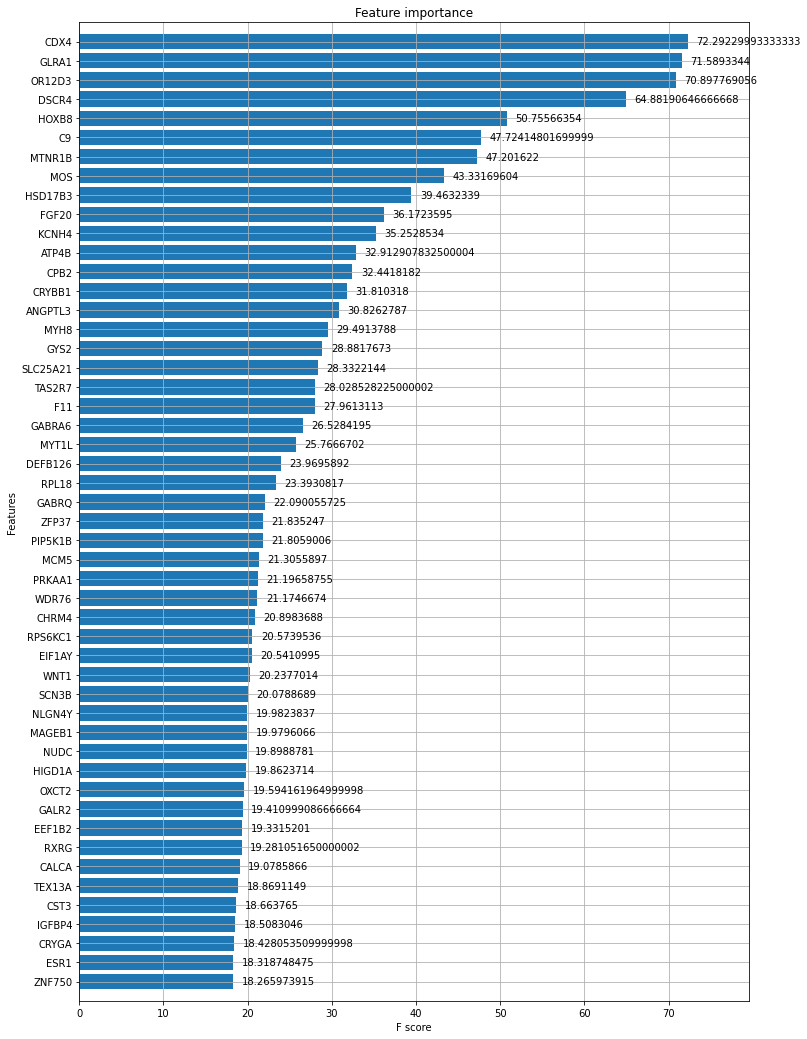

In [74]:
import xgboost as xgb
clf_outcome.get_booster().feature_names = list(X_outcome.columns.values)
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(clf_outcome, max_num_features=50, height=0.8, ax=ax, importance_type='gain')
plt.show()

In [75]:
feature_importance_g= clf_outcome.get_booster().get_score(importance_type='gain')
ranked_features_g = {k: v for k, v in sorted(feature_importance_g.items(), key=lambda x: x[1], reverse=True)}
ranked_genes_g = [gene for gene in ranked_features_g]
ranked_genes_g[:50]

['CDX4',
 'GLRA1',
 'OR12D3',
 'DSCR4',
 'HOXB8',
 'C9',
 'MTNR1B',
 'MOS',
 'HSD17B3',
 'FGF20',
 'KCNH4',
 'ATP4B',
 'CPB2',
 'CRYBB1',
 'ANGPTL3',
 'MYH8',
 'GYS2',
 'SLC25A21',
 'TAS2R7',
 'F11',
 'GABRA6',
 'MYT1L',
 'DEFB126',
 'RPL18',
 'GABRQ',
 'ZFP37',
 'PIP5K1B',
 'MCM5',
 'PRKAA1',
 'WDR76',
 'CHRM4',
 'RPS6KC1',
 'EIF1AY',
 'WNT1',
 'SCN3B',
 'NLGN4Y',
 'MAGEB1',
 'NUDC',
 'HIGD1A',
 'OXCT2',
 'GALR2',
 'EEF1B2',
 'RXRG',
 'CALCA',
 'TEX13A',
 'CST3',
 'IGFBP4',
 'CRYGA',
 'ESR1',
 'ZNF750']

In [76]:
#Parameter tunning for the embedded vectors
emb_df = pd.read_csv("datasets/embedding-vectors/property_vector_moses50_withoutplnresult_2020-12-23.csv", sep="\t")
emb_outcome_df = pd.merge(outcome_df, emb_df, on="patient_ID")
X_emb_outcome, y_emb_outcome = emb_outcome_df[emb_outcome_df.columns.difference(["patient_ID", "posOutcome"])], emb_outcome_df["posOutcome"]
emb_outcome_df.head()

,patient_ID,posOutcome,0,1,2,3,4,5,6,7,...,2223,2224,2225,2226,2227,2228,2229,2230,2231,2232
0,22449,0,-0.090818,-0.093665,0.013321,-0.181485,0.002454,-0.046038,0.005023,-0.148537,...,3.837437e-06,3.315117e-06,8.110773e-07,5.140755e-07,-0.000002,4.659053e-07,1.246811e-07,-5.459261e-07,-1.940580e-08,1.044367e-06
1,22450,0,-0.050184,-0.144434,-0.110672,-0.205783,-0.045798,0.093890,-0.051743,0.010215,...,5.243294e-06,-1.819026e-06,1.511906e-06,-5.381149e-08,0.000001,1.001947e-06,-2.010190e-06,-2.846180e-07,5.900286e-07,2.206977e-07
2,22451,0,-0.081260,-0.118535,0.070830,-0.109890,-0.055652,0.011418,0.008513,-0.139242,...,5.728294e-06,7.688957e-09,-6.358236e-08,-1.185732e-06,0.000002,1.467577e-06,1.072813e-06,3.649615e-07,5.383282e-07,6.781582e-07
3,22452,0,-0.021247,-0.154053,-0.075946,-0.182298,-0.008476,0.134693,-0.041612,0.057590,...,-4.844169e-06,2.724217e-06,3.021055e-06,-1.983205e-06,0.000001,4.689168e-06,3.073779e-06,-1.868303e-07,2.015108e-08,-2.133324e-07
4,22453,1,-0.037702,-0.098500,-0.098706,-0.155622,-0.021875,0.130082,0.004778,0.077166,...,6.608744e-07,3.468912e-06,3.783993e-06,-2.091969e-06,0.000002,1.407070e-06,2.260274e-06,7.934927e-07,-3.723606e-07,-4.706951e-07


In [52]:
clf = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
rand_search_emb = RandomizedSearchCV(clf, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=12,
                                   cv=skf.split(X_emb_outcome, y_emb_outcome), verbose=3, random_state=42)

start_time = timer(None) # timing starts from this point for "start_time" variable
rand_search_emb.fit(X_emb_outcome, y_emb_outcome)
timer(start_time)
print("Best Score: {:.3%}".format(rand_search_emb.best_score_))
print(rand_search_emb.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[12:04:33] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:04:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 41 minutes and 15.14 seconds.
Best Score: 75.976%
{'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 1.5, 'colsample_bytree': 0.8}


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  3.1min
[Parallel(n_jobs=12)]: Done 125 out of 125 | elapsed: 38.3min finished


In [77]:
outcome_emb_params = {'subsample': 1.0, 'n_estimators': 600,
                      'min_child_weight': 2, 'max_depth': 6,
                      'learning_rate': 0.02,
                      'gamma': 2, 'colsample_bytree': 0.6}
outcome_emb_params_2 = {'subsample': 0.8, 'n_estimators': 400,
                        'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 1.5, 'colsample_bytree': 0.8}

In [78]:
outcome_emb_scores, clf_outcome_emb = run_cross_val(X_emb_outcome, y_emb_outcome, outcome_emb_params_2)
outcome_emb_scores_df = pd.DataFrame(data=outcome_emb_scores, columns=["balanced_accuracy", "recall_0", "precision_0", "recall_1", "precision_1", "auc"])
print(outcome_emb_scores_df.describe())

[11:11:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:11:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:12:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:12:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [79]:
outcome_scores_df.to_csv("datasets/results/outcome_scores_raw.csv")
outcome_emb_scores_df.to_csv("datasets/results/outcome_emb_scores_allGO_wo_pln.csv")
print_score_comparison(outcome_scores_df, outcome_emb_scores_df, target_feature="posOutcome", header_2="Embedding All Go")


		posOutcome
			Raw Score		Embedding All Go
		-----------------------------------------------
balanced_accuracy:	71.398%			68.366%

precision_0:		73.792%			74.075%

recall_0:		54.521%			46.577%

precision_1:		76.355%			73.755%

recall_1:		88.275%			90.156%

auc:			80.583%			75.976%



In [80]:
#Infogan 48 vector embedding
gan_df = pd.read_csv("datasets/embedding-vectors/codes_48_infogan_vector.csv")

gan_outcome_df = pd.merge(outcome_df, gan_df, on="patient_ID")
X_gan_outcome, y_gan_outcome = gan_outcome_df[gan_outcome_df.columns.difference(["patient_ID", "posOutcome"])], gan_outcome_df["posOutcome"]
gan_outcome_df.head()

,patient_ID,posOutcome,0,1,2,3,4,5,6,7,...,38,39,40,41,42,43,44,45,46,47
0,22449,0,0.085418,-0.111649,0.018824,0.062400,-0.010372,-0.128282,0.076703,-0.009947,...,-0.047461,0.032504,0.113524,-0.012130,-0.081734,0.028249,0.008334,0.020470,0.031202,-0.002570
1,22450,0,-0.004098,-0.004369,0.014671,-0.028279,-0.065785,-0.159276,0.076940,0.073731,...,-0.061511,0.031983,-0.026282,0.110665,0.018675,-0.016672,-0.009339,-0.113558,0.009888,-0.055047
2,22451,0,0.018527,-0.012835,-0.109397,0.069133,0.052330,-0.050934,0.068238,-0.037115,...,-0.040069,0.040046,0.013243,0.043978,-0.015119,0.009637,0.053755,0.028593,0.036472,0.036024
3,22452,0,-0.000022,0.025746,0.005182,0.058444,0.019806,-0.071137,0.053569,0.007164,...,-0.035705,-0.041495,0.083693,-0.002261,-0.041840,-0.024654,-0.044770,0.040501,-0.125040,-0.072010
4,22453,1,0.012372,0.018869,-0.014388,-0.022910,-0.011056,-0.053580,0.055017,0.072292,...,-0.059993,-0.015497,0.004891,0.070426,0.002443,0.023149,-0.033846,-0.044504,0.041614,-0.071776


In [31]:
clf_gan = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
rand_search_gan_outcome = RandomizedSearchCV(clf_gan, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=12,
                                   cv=skf.split(X_gan_outcome, y_gan_outcome), verbose=3, random_state=42)

start_time = timer(None) # timing starts from this point for "start_time" variable
rand_search_gan_outcome.fit(X_gan_outcome, y_gan_outcome)
timer(start_time)
print("Best Score: {:.3%}".format(rand_search_gan_outcome.best_score_))
print(rand_search_gan_outcome.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[16:41:36] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:41:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 1 minutes and 1.35 seconds.
Best Score: 64.739%
{'subsample': 0.6, 'n_estimators': 300, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.02, 'gamma': 5, 'colsample_bytree': 0.6}


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    4.7s
[Parallel(n_jobs=12)]: Done 125 out of 125 | elapsed:   59.7s finished


In [81]:
outcome_gan_params = {'subsample': 0.6, 'n_estimators': 300, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.02, 'gamma': 5, 'colsample_bytree': 0.6}

In [84]:
outcome_gan_scores, clf_outcome_gan = run_cross_val(X_gan_outcome, y_gan_outcome, outcome_gan_params)
outcome_gan_scores_df  = pd.DataFrame(data=outcome_gan_scores, columns=["balanced_accuracy", "recall_0", "precision_0", "recall_1", "precision_1", "auc"])
outcome_gan_scores_df.to_csv("datasets/results/outcome_scores_gan_48.csv")
print(outcome_gan_scores_df.describe())

[11:18:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:18:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:18:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:18:12] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [85]:
print_score_comparison(outcome_scores_df, outcome_gan_scores_df, target_feature="posOutcome",
                       header_2="Infogan Embedding")

		posOutcome
			Raw Score		Infogan Embedding
		-----------------------------------------------
balanced_accuracy:	71.398%			56.765%

precision_0:		73.792%			57.068%

recall_0:		54.521%			25.036%

precision_1:		76.355%			66.256%

recall_1:		88.275%			88.494%

auc:			80.583%			64.739%



In [86]:
print_score_comparison(outcome_emb_scores_df, outcome_gan_scores_df, target_feature="posOutcome",
                       header_1="All GO Embedding", header_2="Infogan Embedding")

		posOutcome
			All GO Embedding		Infogan Embedding
		-----------------------------------------------
balanced_accuracy:	68.366%			56.765%

precision_0:		74.075%			57.068%

recall_0:		46.577%			25.036%

precision_1:		73.755%			66.256%

recall_1:		90.156%			88.494%

auc:			75.976%			64.739%



In [87]:
xgb50_emb_df = pd.read_csv("datasets/embedding-vectors/property_vector_xgb50_withoutplnresult_2020-12-23.csv", sep="\t")

xgb50_outcome_df = pd.merge(outcome_df, xgb50_emb_df, on="patient_ID")
X_xgb50_outcome, y_xg50_outcome = xgb50_outcome_df[xgb50_outcome_df.columns.difference(["patient_ID", "posOutcome"])], xgb50_outcome_df["posOutcome"]
xgb50_outcome_df.head()

,patient_ID,posOutcome,0,1,2,3,4,5,6,7,...,2221,2222,2223,2224,2225,2226,2227,2228,2229,2230
0,22449,0,-0.034369,0.100596,-0.078138,-0.156778,0.033399,-0.034370,-0.041319,0.129652,...,2.983482e-06,-5.667081e-06,-2.578453e-06,3.233320e-06,3.162931e-06,-1.622541e-07,-2.522139e-06,7.292363e-07,2.538494e-07,2.798644e-08
1,22450,0,-0.054903,-0.075209,-0.112222,-0.154311,-0.091096,0.092032,-0.108843,-0.003543,...,2.859682e-06,7.411624e-07,-3.327798e-07,-7.720635e-07,-3.062798e-06,-2.325743e-07,-6.893824e-07,-1.527674e-06,2.051379e-06,3.103411e-07
2,22451,0,-0.073419,0.122474,-0.069371,-0.090356,-0.005811,-0.010133,-0.118635,0.158897,...,1.504380e-06,6.565640e-06,4.819232e-07,-2.377132e-06,7.905603e-07,-1.038275e-06,-9.005510e-07,9.035374e-07,4.423281e-07,5.704054e-08
3,22452,0,-0.062597,-0.091468,-0.128039,-0.178147,-0.058901,0.130499,-0.060918,0.019998,...,6.847706e-07,2.294943e-06,9.302902e-07,-7.566930e-07,-5.137400e-07,2.965493e-06,1.247254e-06,2.925552e-07,9.689832e-07,5.092384e-09
4,22453,1,-0.014186,-0.058261,-0.107034,-0.179783,-0.100780,0.105505,-0.019622,-0.005985,...,-5.978619e-07,6.835914e-08,-1.627280e-06,-2.343308e-06,-3.645692e-07,-2.182235e-06,1.108295e-06,5.456489e-07,2.321873e-06,-1.789428e-07


In [38]:
clf_xgb50 = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=4)
rand_search_xgb50_outcome = RandomizedSearchCV(clf_xgb50, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=8,
                                   cv=skf.split(X_xgb50_outcome, y_xg50_outcome), verbose=3, random_state=42)

start_time = timer(None) # timing starts from this point for "start_time" variable
rand_search_xgb50_outcome.fit(X_xgb50_outcome, y_xg50_outcome)
timer(start_time)
print("Best Score: {:.3%}".format(rand_search_xgb50_outcome.best_score_))
print(rand_search_xgb50_outcome.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[17:53:19] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:53:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 47 minutes and 35.01 seconds.
Best Score: 76.871%
{'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 5, 'colsample_bytree': 0.6}


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  6.6min
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed: 46.5min finished


In [88]:
xgb50_params = {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 5, 'colsample_bytree': 0.6}

In [89]:
outcome_xgb50_scores, clf_xgb50_outcome = run_cross_val(X_xgb50_outcome, y_xg50_outcome, xgb50_params)
outcome_xgb50_scores_df = pd.DataFrame(data=outcome_xgb50_scores, columns=["balanced_accuracy", "recall_0", "precision_0", "recall_1", "precision_1", "auc"])
outcome_xgb50_scores_df.to_csv("datasets/results/outcome_scores_xgb50_wo_pln.csv")
print(outcome_xgb50_scores_df.describe())

[11:19:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:20:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:20:33] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:20:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [90]:
print_score_comparison(outcome_scores_df, outcome_xgb50_scores_df, target_feature="posOutcome", header_2="Xgb50 Embedding")

		posOutcome
			Raw Score		Xgb50 Embedding
		-----------------------------------------------
balanced_accuracy:	71.398%			68.908%

precision_0:		73.792%			72.830%

recall_0:		54.521%			48.744%

precision_1:		76.355%			74.316%

recall_1:		88.275%			89.072%

auc:			80.583%			76.871%



In [91]:
print_score_comparison(outcome_emb_scores_df, outcome_xgb50_scores_df, target_feature="posOutcome",
                       header_1="Embedding All GO",
                       header_2="Xgb50 Embedding")

		posOutcome
			Embedding All GO		Xgb50 Embedding
		-----------------------------------------------
balanced_accuracy:	68.366%			68.908%

precision_0:		74.075%			72.830%

recall_0:		46.577%			48.744%

precision_1:		73.755%			74.316%

recall_1:		90.156%			89.072%

auc:			75.976%			76.871%



In [94]:
xgb50_go_emb_df = pd.read_csv("datasets/embedding-vectors/property_vector_xgb50-allGO-PW_2020-12-25.csv", sep='\t')
xgb50_go_emb_outcome_df = pd.merge(outcome_df, xgb50_go_emb_df, on="patient_ID")
X_xgb50_go_emb_outcome, y_xg50_go_outcome = xgb50_go_emb_outcome_df[xgb50_go_emb_outcome_df.columns.difference(["patient_ID", "posOutcome"])], xgb50_go_emb_outcome_df["posOutcome"]
xgb50_go_emb_outcome_df.head()

,patient_ID,posOutcome,0,1,2,3,4,5,6,7,...,2221,2222,2223,2224,2225,2226,2227,2228,2229,2230
0,22449,0,-0.034369,0.100596,-0.078138,-0.156778,0.033399,-0.034370,-0.041319,0.129652,...,2.983482e-06,-5.667081e-06,-2.578453e-06,3.233320e-06,3.162931e-06,-1.622541e-07,-2.522139e-06,7.292363e-07,2.538494e-07,2.798644e-08
1,22450,0,-0.054903,-0.075209,-0.112222,-0.154311,-0.091096,0.092032,-0.108843,-0.003543,...,2.859682e-06,7.411624e-07,-3.327798e-07,-7.720635e-07,-3.062798e-06,-2.325743e-07,-6.893824e-07,-1.527674e-06,2.051379e-06,3.103411e-07
2,22451,0,-0.073419,0.122474,-0.069371,-0.090356,-0.005811,-0.010133,-0.118635,0.158897,...,1.504380e-06,6.565640e-06,4.819232e-07,-2.377132e-06,7.905603e-07,-1.038275e-06,-9.005510e-07,9.035374e-07,4.423281e-07,5.704054e-08
3,22452,0,-0.062597,-0.091468,-0.128039,-0.178147,-0.058901,0.130499,-0.060918,0.019998,...,6.847706e-07,2.294943e-06,9.302902e-07,-7.566930e-07,-5.137400e-07,2.965493e-06,1.247254e-06,2.925552e-07,9.689832e-07,5.092385e-09
4,22453,1,-0.014186,-0.058261,-0.107034,-0.179783,-0.100780,0.105505,-0.019622,-0.005985,...,-5.978619e-07,6.835914e-08,-1.627280e-06,-2.343308e-06,-3.645692e-07,-2.182235e-06,1.108295e-06,5.456489e-07,2.321873e-06,-1.789428e-07


In [95]:
clf_xgb50_go = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=4)
rand_search_xgb50_go_outcome = RandomizedSearchCV(clf_xgb50_go, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=8,
                                   cv=skf.split(X_xgb50_go_emb_outcome, y_xg50_go_outcome), verbose=3, random_state=42)

start_time = timer(None) # timing starts from this point for "start_time" variable
rand_search_xgb50_go_outcome.fit(X_xgb50_go_emb_outcome, y_xg50_go_outcome)
timer(start_time)
print("Best Score: {:.3%}".format(rand_search_xgb50_go_outcome.best_score_))
print(rand_search_xgb50_go_outcome.best_params_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[12:14:06] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:14:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 43 minutes and 28.25 seconds.
Best Score: 76.871%
{'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 5, 'colsample_bytree': 0.6}


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:  6.1min
[Parallel(n_jobs=8)]: Done 125 out of 125 | elapsed: 42.4min finished


In [112]:
xgb50_params_go = {'subsample': 0.8, 'n_estimators': 600, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 5, 'colsample_bytree': 0.6}

In [113]:
outcome_xgb50_go_scores, clf_xgb50_go_outcome = run_cross_val(X_xgb50_go_emb_outcome, y_xg50_go_outcome, xgb50_params_go)
outcome_xgb50_go_scores_df = pd.DataFrame(data=outcome_xgb50_go_scores, columns=["balanced_accuracy", "recall_0", "precision_0", "recall_1", "precision_1", "auc"])
outcome_xgb50_go_scores_df.to_csv("datasets/results/outcome_scores_xgb50_pln.csv")
print(outcome_xgb50_go_scores_df.describe())

[12:34:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:34:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:35:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:35:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [114]:

print_score_comparison(outcome_xgb50_scores_df, outcome_xgb50_go_scores_df, target_feature="posOutcome",
                       header_1="Xgb50 Embedding w/o GO",
                       header_2="Xgb50 Embedding with GO")

		posOutcome
			Xgb50 Embedding w/o GO		Xgb50 Embedding with GO
		-----------------------------------------------
balanced_accuracy:	68.908%			68.908%

precision_0:		72.830%			72.830%

recall_0:		48.744%			48.744%

precision_1:		74.316%			74.316%

recall_1:		89.072%			89.072%

auc:			76.871%			76.871%



In [115]:
go_emb_df = pd.read_csv("datasets/embedding-vectors/property_vector_moses50-allGO-pW_2020-12-25.csv", sep="\t")
go_emb_outcome_df = pd.merge(outcome_df, go_emb_df, on="patient_ID")
X_go_emb_outcome, y_go_emb_outcome = go_emb_outcome_df[go_emb_outcome_df.columns.difference(["patient_ID", "posOutcome"])], go_emb_outcome_df["posOutcome"]
go_emb_outcome_df.head()


,patient_ID,posOutcome,0,1,2,3,4,5,6,7,...,2223,2224,2225,2226,2227,2228,2229,2230,2231,2232
0,22449,0,-0.090818,-0.093665,0.013321,-0.181485,0.002454,-0.046038,0.005023,-0.148537,...,3.837437e-06,3.315117e-06,8.110773e-07,5.140755e-07,-0.000002,4.659053e-07,1.246811e-07,-5.459261e-07,-1.940580e-08,1.044367e-06
1,22450,0,-0.050184,-0.144434,-0.110672,-0.205783,-0.045798,0.093890,-0.051743,0.010215,...,5.243294e-06,-1.819026e-06,1.511906e-06,-5.381149e-08,0.000001,1.001947e-06,-2.010190e-06,-2.846180e-07,5.900286e-07,2.206977e-07
2,22451,0,-0.081260,-0.118535,0.070830,-0.109890,-0.055652,0.011418,0.008513,-0.139242,...,5.728294e-06,7.688957e-09,-6.358236e-08,-1.185732e-06,0.000002,1.467577e-06,1.072813e-06,3.649615e-07,5.383282e-07,6.781582e-07
3,22452,0,-0.021247,-0.154053,-0.075946,-0.182298,-0.008476,0.134693,-0.041612,0.057590,...,-4.844169e-06,2.724217e-06,3.021055e-06,-1.983205e-06,0.000001,4.689168e-06,3.073779e-06,-1.868303e-07,2.015108e-08,-2.133324e-07
4,22453,1,-0.037702,-0.098500,-0.098706,-0.155622,-0.021875,0.130082,0.004778,0.077166,...,6.608744e-07,3.468912e-06,3.783993e-06,-2.091969e-06,0.000002,1.407070e-06,2.260274e-06,7.934927e-07,-3.723606e-07,-4.706951e-07


In [116]:
clf = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)
rand_search_emb_go = RandomizedSearchCV(clf, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=12,
                                   cv=skf.split(X_go_emb_outcome, y_go_emb_outcome), verbose=3, random_state=42)

start_time = timer(None) # timing starts from this point for "start_time" variable
rand_search_emb_go.fit(X_go_emb_outcome, y_go_emb_outcome)
timer(start_time)
print("Best Score: {:.3%}".format(rand_search_emb_go.best_score_))
print(rand_search_emb_go.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[13:20:52] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:20:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 42 minutes and 4.25 seconds.
Best Score: 75.976%
{'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 1.5, 'colsample_bytree': 0.8}


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  3.0min
[Parallel(n_jobs=12)]: Done 125 out of 125 | elapsed: 39.1min finished


In [117]:
outcome_emb_go_params = {'subsample': 0.8, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.03, 'gamma': 1.5, 'colsample_bytree': 0.8}

In [118]:
outcome_emb_go_scores, clf_emb_go = run_cross_val(X_go_emb_outcome, y_go_emb_outcome, outcome_emb_go_params)
outcome_emb_go_scores_df = pd.DataFrame(data=outcome_emb_go_scores, columns=["balanced_accuracy", "recall_0", "precision_0", "recall_1", "precision_1", "auc"])
outcome_emb_go_scores_df.to_csv("datasets/results/outcome_scores_go_pln.csv")
print(outcome_emb_go_scores_df.describe())

[13:30:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:30:59] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:31:19] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:31:40] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [119]:
print_score_comparison(outcome_emb_scores_df, outcome_emb_go_scores_df, target_feature="posOutcome",
                       header_1="Embedding w/o GO-PW", header_2="Embedding with GO-PW")

		posOutcome
			Embedding w/o GO-PW		Embedding with GO-PW
		-----------------------------------------------
balanced_accuracy:	68.366%			68.366%

precision_0:		74.075%			74.075%

recall_0:		46.577%			46.577%

precision_1:		73.755%			73.755%

recall_1:		90.156%			90.156%

auc:			75.976%			75.976%

